<a href="https://colab.research.google.com/github/cfrc2694/HEP_Exercises/blob/main/04_Data_vs_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introductional notebook to HEP analysis in C++

<p>In this notebook you can find an easy set of commands that show some basic computing techniques commonly used in High Energy Physics (HEP) analyzes.</p>

<p>It also shows how to create an histogram, fill it and draw it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. The final output is a plot with the number of leptons.</p>

Based on ATLAS opendata notebooks (http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)


The library used is [ROOT](https://root.cern.ch/), a scientific data analysis software framework that provides a large set of functionalities needed to deal with big data processing, statistical analysis, visualisation and storage.

<p>At first we have to include several helpers that will support our analysis:</p>

In [ ]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if (IN_COLAB):
  !apt -qq install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion python2.7
  if (os.path.isdir("/content/root")):
    pass
  else:
    !gdown https://drive.google.com/uc?id=1bWgcTAMG7IoyQASWwrrOQrGe4haUAo9t
    !cd /; tar xzf /content/root_for_colab.tar.gz
    !rm -rf root_for_colab.tar.gz*
  import sys
  sys.path.append("/content/root/build/")
  sys.path.append("/content/root/build/bin/")
  sys.path.append("/content/root/build/include/")
  sys.path.append("/content/root/build/lib/")

import ROOT
from ROOT import *

Welcome to JupyROOT 6.25/01


Next we have to open the data that we want to analyze. As described above the data is stored in a _*.root_ file. This is a root file containing tracks and calorimeter clusters

In [ ]:
file_name='Data_8TeV.root'
#f = ROOT.TFile.Open("http://csandova.web.cern.ch/csandova/HEP-Ex-Course/Code/TTbarSel/Data_8TeV.root")
if (os.path.isfile(file_name)):
    pass
else :
    !wget http://csandova.web.cern.ch/csandova/HEP-Ex-Course/Code/TTbarSel/Data_8TeV.root -O Data_8TeV.root
f = TFile.Open(file_name)

The next step is to define a tree named _tree_ to get the data out of the _*.root_ file. The tree in this root file is called "JetRecoTree". We will then print the contents of the tree to find the names of the variables. 

In [ ]:
tree = f.Get("mini")
tree.Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries : 14945674 : Total =      3737586466 bytes  File  Size = 1366006484 *
*        :          : Tree compression factor =   2.74                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries : 14945674 : Total  Size=   59789737 bytes  File Size  =     297928 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression= 200.68     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries : 14945674 : Total  Size=   59789885 bytes  File Size  =   44412272 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression=   1.35     *
*...................................................

Create Canvas

In [ ]:
canvas = TCanvas("Canvas","",800,600);

Create histograms: Leading jet pT and all jets pT 

In [ ]:
cutflow = TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
hist_njets = TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);

Loop and fill histograms

In [ ]:
!pip install etaprogress
import sys
import time
from etaprogress.progress import ProgressBar
bar = ProgressBar(tree.GetEntries(), max_width=100)

In [ ]:
printEachPercent=10

cut1 = 0
cut2 = 0
cut3 = 0
cut4 = 0
cut5 = 0
cut6 = 0
cut7 = 0
cut8 = 0

bar.numerator = 0
print(bar)
nEvents =tree.GetEntries()
nSplits=int(100/printEachPercent)

for event in tree:
    bar.numerator+=1
    i=bar.numerator
    if int(nSplits*i/nEvents)!=int(nSplits*(i-1)/nEvents):
        print(bar)
    cutflow.Fill(0)
    
    #First cut: Good vertex
    good_vtx = tree.hasGoodVertex
    ##Discard all events without a good vertex
    if not good_vtx: continue
    cut1+=1
    cutflow.Fill(1)
    
    #Second cut: Trigger
    e_trig = tree.trigE
    mu_trig = tree.trigM
    
    ##Discard all events without a e_trig and a mu_trig
    if ((not e_trig) and (not mu_trig)) : continue
    cut2+=1
    cutflow.Fill(2)
    
    ##Preselection of good leptons                                                                                
    n_mu=0
    n_el=0
    n_lep=0
    index_lep = []
    lep_pt = tree.lep_pt
    lep_phi = tree.lep_phi
    lep_eta = tree.lep_eta
    lep_E = tree.lep_E
    lep_ptcone30=tree.lep_ptcone30
    lep_etcone20=tree.lep_etcone20
    lep_n = tree.lep_n
    lep_type =tree.lep_type
    
    for i in range(lep_n):
        if( lep_pt[i] < 24e3): continue 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ): continue
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ): continue  
        if( lep_type[i]==13 and TMath.Abs(lep_eta[i]) < 2.5 ):  n_mu+=1
        #To complete: Add electrons and extract the index for the good lepton
        eta_lep=TMath.Abs(lep_eta[i])
        good_electron = eta_lep < 2.47 and (eta_lep < 1.37 or eta_lep >1.52 )
        if( lep_type[i]==11 and good_electron ):  n_el+=1
        index_lep.append(i)
        n_lep+=1
    
    #Select events with only 1 good lepton and fill the cutflow histogram 
    #Example:
    #Third cut (one good lepton):
    if not n_lep==1 : continue
    cut3+=1
    cutflow.Fill(3)
    
    #Fourth cut: At least 4 jets
    ##Number of jets distribution
    jet_n=tree.jet_n
    hist_njets.Fill(jet_n)
    if(jet_n<4): continue
    cutflow.Fill(4)
    cut4+=1
    
    #Searching good jets
    n_jets=0
    n_bjets=0
    jet_pt=tree.jet_pt
    jet_eta=tree.jet_eta
    jet_mv1=tree.jet_MV1
    jet_jvf=tree.jet_jvf
    for j in range(jet_n):
        if(jet_pt[j] < 25e3): continue
        #To complete: apply jet cuts to find the good jets
        if(jet_eta[j] > 2.5): continue
        if(jet_pt[j] < 50e3 )and(jet_jvf[j]<0.59)and(jet_eta[j] > 2.4): continue
        n_jets+=1
        #cut on 0.7892 MV1 and count the number of b-jets
        if(jet_mv1[j]>=0.7892): 
            n_bjets+=1
    
    #Fifth cut: At least 4 good jets
    if(n_jets < 4): continue
    cutflow.Fill(5)
    cut5+=1
    
    #Sixth cut: At least 2 good bjets
    if(n_bjets<2): continue
    cutflow.Fill(6)
    cut6+=1
    
    #Seventh cut: MET > 30 GeV
    MET=tree.met_et
    if(MET<30e3): continue
    cutflow.Fill(7)
    cut7+=1
    
    ##TLorentzVector definitions
    Lepton  = TLorentzVector()
    MeT  = TLorentzVector()
    ##To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0])
    MeT.SetPtEtaPhiE(MET,0,tree.met_phi,MET)
        
    ##Calculation of the mTW using TLorentz vectors
    mTW = TMath.Sqrt(2.*Lepton.Pt()*MeT.Et()*(1.-cos(Lepton.DeltaPhi(MeT))))
    
    ##Eight cut: mTW > 30 GeV
    if(mTW<30e3): continue
    cutflow.Fill(8)
    cut8+=1

print("Done!")
print("All events:" + str(nEvents))
print("Cut1:" + str(cut1))
print("Cut2:" + str(cut2))
print("Cut3:" + str(cut3))
print("Cut4:" + str(cut4))
print("Cut5:" + str(cut5))
print("Cut6:" + str(cut6))
print("Cut7:" + str(cut7))
print("Cut8:" + str(cut8))

  0% (       0/14945674) [                                         ] eta --:-- /
 10% ( 1494568/14945674) [####                                     ] eta 20:27 -
 20% ( 2989135/14945674) [########                                 ] eta 18:42 \
 30% ( 4483703/14945674) [############                             ] eta 16:29 |
 40% ( 5978270/14945674) [################                         ] eta 13:27 /
 50% ( 7472837/14945674) [####################                     ] eta 13:01 -
 60% ( 8967405/14945674) [########################                 ] eta 11:10 \
 70% (10461972/14945674) [############################             ] eta 06:55 |
 80% (11956540/14945674) [################################         ] eta 04:50 /
 90% (13451107/14945674) [####################################     ] eta 02:24 -
100% (14945674/14945674) [#########################################] eta 00:01 \
Done!
All events:14945674
Cut1:14656440
Cut2:14656440
Cut3:11543234
Cut4:61901
Cut5:61669
Cut6:10802
Cut7:855

Draw

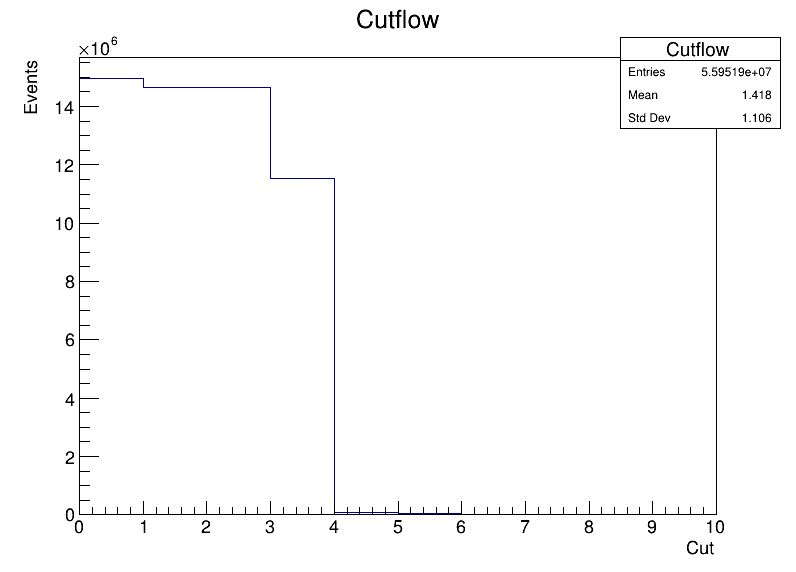

In [ ]:
cutflow.Draw("");
canvas.Draw();

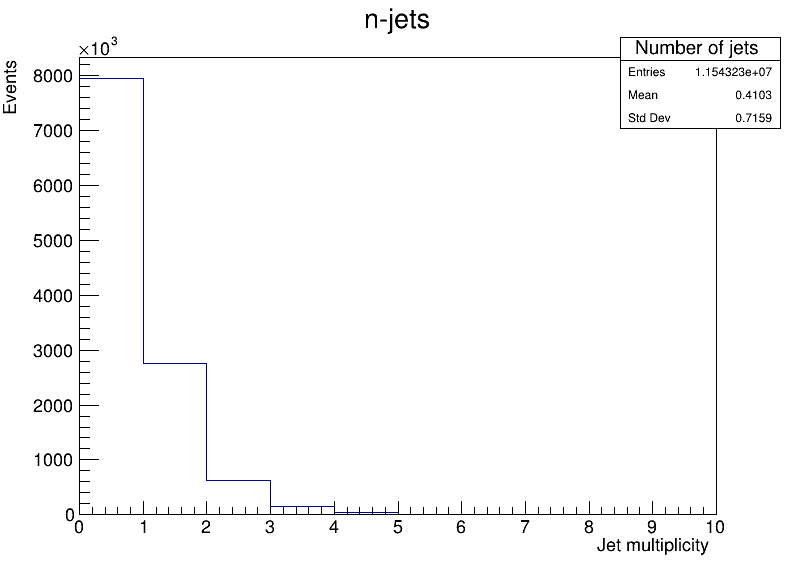

In [ ]:
hist_njets.Draw();
canvas.Draw();

In [ ]:
c = TCanvas("Canvas3","",800,600)
pt_all_lepts=TH1F("pt_all_lepts", "Pt_{#ell}; (MeV); entries", 100, 0.0, 1000.0)
track_isolation_lepts=TH1F("track_isolation_lepts", "; (MeV); entries", 100, 0.0, 1.0)
cal_isolation_lepts=TH1F("pt_all_lepts", "; (MeV); entries", 100, 0.0, 1.0)
eta_all_lepts=TH1F("eta_all_lepts", "#eta_tau2", 100, -5, 5)

Warning in <TFile::Append>: Replacing existing TH1: pt_all_lepts (Potential memory leak).


In [ ]:
def FillHistos(event):
    lep_pt = event.lep_pt
    lep_phi = event.lep_phi
    lep_eta = event.lep_eta
    lep_E = event.lep_E
    lep_ptcone30=event.lep_ptcone30
    lep_etcone20=event.lep_etcone20
    lep_n = event.lep_n
    lep_type =event.lep_type
    for i in range(event.lep_n):
        pt_all_lepts.Fill(lep_pt[i])
        eta_all_lepts.Fill(lep_eta[i])
        track_isolation_lepts.Fill(lep_ptcone30[i]/lep_pt[i])
        cal_isolation_lepts.Fill(lep_etcone20[i]/lep_pt[i])
    n_jets=0
    n_bjets=0
    jet_pt=event.jet_pt
    jet_eta=event.jet_eta
    jet_mv1=event.jet_MV1
    jet_jvf=event.jet_jvf
    for j in range(jet_n):

In [ ]:
for event in tree:
  FillHistos(event)

KeyboardInterrupt: 

In [ ]:
hist_njets.Draw();
canvas.SaveAs("03_Distro_Plots.pdf");

Info in <TCanvas::Print>: pdf file 03_Distro_Plots.pdf has been created
